# Humor Detection Project

In [ ]:
import numpy as np
import pandas as pd

import nltk
import string
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

## Reading in pickle files and CSVs

In [ ]:
oneliners = pd.read_pickle('humorous_oneliners.pickle') # supposed to be funny
proverbs = pd.read_pickle('proverbs.pickle') # not funny
reuters_headlines = pd.read_pickle('reuters_headlines.pickle') # not funny
wiki_sentences = pd.read_pickle('wiki_sentences.pickle') # not funny

In [ ]:
shortjokes = pd.read_csv('shortjokes.csv') # supposed to be funny
shortjokes_df = shortjokes.drop(['ID'], axis = 1).rename(columns = {"Joke": "Line"}).sample(frac = 0.02, replace = False)
shortjokes_df['Funny'] = 1

In [ ]:
print("oneliners length: ", len(oneliners))
print("shortjokes length: ", len(shortjokes_df))
print("proverbs length: ", len(proverbs))
print("reuters length: ", len(reuters_headlines))
print("wiki length: ", len(wiki_sentences))

oneliners length:  5251
shortjokes length:  4633
proverbs length:  1019
reuters length:  5243
wiki length:  5251


In [ ]:
oneliner_df = pd.DataFrame(data = {'Line': oneliners, 'Funny': 1})
proverbs_df = pd.DataFrame(data = {'Line': proverbs, 'Funny': 0})
reuters_headlines_df = pd.DataFrame(data = {'Line': reuters_headlines, 'Funny': 0})
wiki_sentences_df = pd.DataFrame(data = {'Line': wiki_sentences, 'Funny': 0})

# data is a 2 column dataframe with one column containing the joke and the other denoting whether it is funny(1) or not(0)
data = pd.concat([oneliner_df, proverbs_df, reuters_headlines_df, wiki_sentences_df, shortjokes_df])

# we only want to randomly sample half of our dataframe
data = data.sample(frac = 0.25, replace = False)
og_data = data.copy()

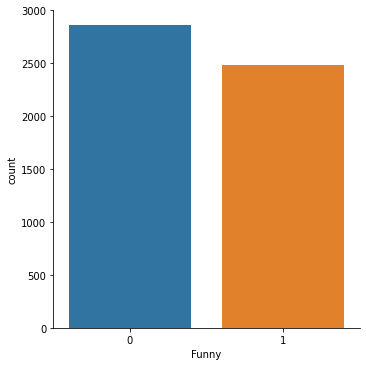

In [ ]:
sns.catplot(x='Funny', kind = 'count', data = data)

## Data Cleaning

In [ ]:
# Check for null values.
print(data.isnull().any(axis = 0))

Line     False
Funny    False
dtype: bool


In [ ]:
# Tokenize
''' Splits elements in the Line series into lists of words. '''
def Tokenize(string):
    lst = string.split()
    return lst

data["Line"] = data["Line"].apply(Tokenize)

In [ ]:
# lower case
''' Takes in a tokenized list and makes all words lower case. '''
def lower_case(lst):
    lowered = []
    for i in lst:
        lowered.append(i.lower())
    return lowered
    
data["Line"] = data["Line"].apply(lower_case)

In [ ]:
# remove punctuation and symbols
''' Removed punctuation from tokenized list. '''
def remove_punc(lst):
    removed = []
    for i in lst:
        stripped = i.strip(string.punctuation)
        if stripped is not '':
            removed.append(stripped)
    return removed
    
data["Line"] = data["Line"].apply(remove_punc)

In [ ]:
# remove numbers
''' Removed numbers from tokenized list. '''
def remove_numbers(lst):
    numbers = "0123456789"
    no_numbers = []
    for i in lst:
        i = ''.join([j for j in i if not j.isdigit()])
        no_numbers.append(i)
    return no_numbers

data["Line"] = data["Line"].apply(remove_numbers)

In [ ]:
# remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words("english")

''' Removes stopwords from tokenized list. '''
def remove_stopwords(lst):
    return [i for i in lst if not i in english_stopwords]
    
data["Line"] = data["Line"].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

''' Lemmatizes words in a tokenized list'''
def lemmatize(lst):
    lemmatized_words = []
    for i in lst:
        lemmatized_words.append(wordnet_lemmatizer.lemmatize(i, pos = "v"))
    return lemmatized_words
    
data["Line"] = data["Line"].apply(lemmatize)
#data

## Machine Learning

#### TF-IDF

In [ ]:

data['Line'] = data['Line'].apply(lambda x: ''.join(i+' ' for i in x))

#data

In [ ]:
og_data.to_csv('master_dataset.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf = train_test_split(data.Line, data.Funny, test_size = 0.2, random_state = 2)
train_x_ngram, test_x_ngram, train_y_ngram, test_y_ngram = train_test_split(og_data.Line, og_data.Funny, test_size = 0.2, random_state = 2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# without ngram 
tfidf = TfidfVectorizer() 
train_1_tfidf = tfidf.fit_transform(train_x_tfidf)
test_1_tfidf = tfidf.transform(test_x_tfidf)

# with ngram 
tfidf_ngram = TfidfVectorizer(ngram_range = (1, 2))  
train_1_ngram = tfidf_ngram.fit_transform(train_x_ngram)
test_1_ngram = tfidf_ngram.transform(test_x_ngram)

In [ ]:
# without ngram 
train_arr_tfidf = train_1_tfidf.toarray()
test_arr_tfidf = test_1_tfidf.toarray()

# with ngram
train_arr_ngram = train_1_ngram.toarray()
test_arr_ngram = test_1_ngram.toarray()

#### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression w/out ngram
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(train_arr_tfidf, train_y_tfidf)
logreg_tfidf_predicted = logreg_tfidf.predict(test_arr_tfidf)
logreg_accuracy_tfidf = accuracy_score(test_y_tfidf, logreg_tfidf_predicted) * 100
print("Accuracy: ", logreg_accuracy_tfidf)

print("------------------------------------------")

# Logistic Regression w/ngram
logreg_ngram = LogisticRegression()
logreg_ngram.fit(train_arr_ngram, train_y_ngram)
logreg_ngram_predicted = logreg_ngram.predict(test_arr_ngram)
logreg_accuracy_ngram = accuracy_score(test_y_ngram, logreg_ngram_predicted) * 100
print("w/ngram Accuracy: ", logreg_accuracy_ngram)

Accuracy:  87.94392523364486
------------------------------------------
w/ngram Accuracy:  91.49532710280374


#### Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Naive Bayes w/out ngram
nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_arr_tfidf, train_y_tfidf)
nb_tfidf_predicted = nb_tfidf.predict(test_arr_tfidf)
nb_accuracy_tfidf = accuracy_score(test_y_tfidf, nb_tfidf_predicted) * 100
print("Accuracy: ", nb_accuracy_tfidf)

print("------------------------------------------")

# Naive Bayes w/ngram\
nb_ngram = MultinomialNB()
nb_ngram.fit(train_arr_ngram, train_y_ngram)
nb_ngram_predicted = nb_ngram.predict(test_arr_ngram)
nb_accuracy_ngram = accuracy_score(test_y_ngram, nb_ngram_predicted) * 100
print("w/ngram Accuracy: ", nb_accuracy_ngram)

Accuracy:  88.69158878504673
------------------------------------------
w/ngram Accuracy:  91.30841121495327


#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, accuracy_score

#SVM w/out ngram
svc_tfidf = LinearSVC()
svc_tfidf.fit(train_arr_tfidf, train_y_tfidf)
svc_tfidf_predicted = svc_tfidf.predict(test_arr_tfidf)
svc_accuracy_tfidf = accuracy_score(test_y_tfidf, svc_tfidf_predicted) * 100
print("Accuracy: ", svc_accuracy_tfidf)

print("------------------------------------------")

# SVM w/ngram
svc_ngram = LinearSVC()
svc_ngram.fit(train_arr_ngram, train_y_ngram)
svc_ngram_predicted = svc_ngram.predict(test_arr_ngram)
svc_accuracy_ngram = accuracy_score(test_y_ngram, svc_ngram_predicted) * 100
print("w/ngram Accuracy: ", svc_accuracy_ngram)

Accuracy:  88.59813084112149
------------------------------------------
w/ngram Accuracy:  92.71028037383178


In [ ]:
results = pd.DataFrame({'Model': ['Logsitic Regression', 'Naive Bayes', 'SVC'],
                        'TF-IDF': [logreg_accuracy_tfidf, nb_accuracy_tfidf, svc_accuracy_tfidf],
                        'w/ N-Grams': [logreg_accuracy_ngram, nb_accuracy_ngram, svc_accuracy_ngram],
})
results = results.sort_values(by = 'Model', ascending = False)
results

,Model,TF-IDF,w/ N-Grams
2,SVC,88.598131,92.710280
1,Naive Bayes,88.691589,91.308411
0,Logsitic Regression,87.943925,91.495327
